In [1]:
"""
- Transforming the dataset into a classification problem
- Solving the imbalance of the dataset
- Using multiple classification methods: This step takes a lot of time
"""

'\n- Transforming the dataset into a classification problem\n- Solving the imbalance of the dataset\n- Using multiple classification methods: This step takes a lot of time\n'

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# scikit metrics
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# For imbalanced data
from imblearn.over_sampling import SMOTE

# Import Classification methods
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Hypertuning
import optuna
from optuna import Trial
import gc # garbage collector, to clean up and free memory


In [2]:
# Import Data:
df = pd.read_csv('data/labelencoded_data.csv',index_col=0)

# Drop unnecessary and duplicate columns 
df.drop(['id', 'std', 'sta', 'fltid','arr_iata','dep_iata','ac'], axis=1,inplace=True)

# Converting the target column into a classification problem
df['delayed'] = df['target'] >0.1

# Categorical columns - req. for the fit
# category_cols = ['datop','depstn','arrstn','status','arr_country','dep_country','season','airline_code','international_flight','delayed','year','month','day'] # 12
category_cols = ['datop','depstn','arrstn','status','arr_country','dep_country','season','airline_code','international_flight','year','month','day'] # 12
numerical_cols   = ['target','dep_elevation','arr_elevation','flight_time_in_min','flight_distance_in_km','average_flight_speed_km_h','elevation_dif','std_time','sta_time','arr_lat','arr_lon','dep_lat','dep_lon'] # 13


In [4]:
df.head().T

,0,1,2,3,4
datop,20160103,20160113,20160116,20160117,20160117
depstn,31,86,123,37,123
arrstn,119,119,58,91,4
status,0,0,0,0,0
target,260.0,20.0,0.0,0.0,22.0
dep_country,31,26,51,51,51
dep_elevation,656.0,768.0,22.0,19.0,22.0
dep_lat,33.3675,45.6306,36.851002,33.875,36.851002
dep_lon,-7.58997,8.72811,10.2272,10.7755,10.2272
arr_country,48,48,49,17,14


In [5]:
df.shape

(107833, 26)

<Axes: >

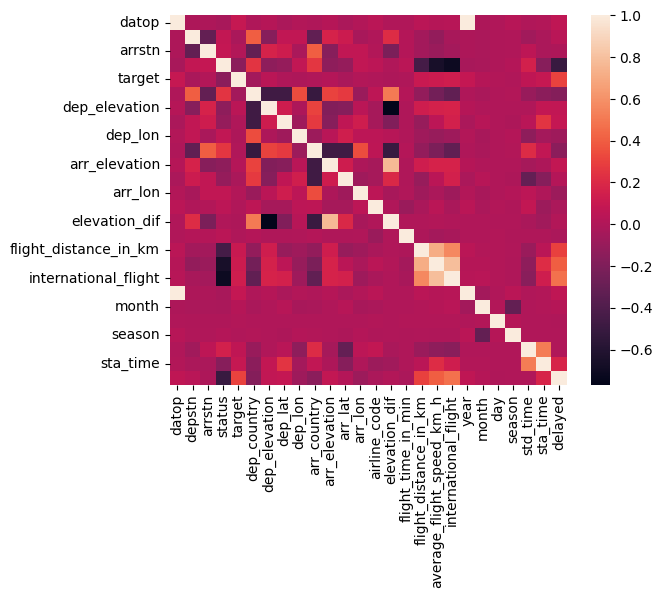

In [6]:
# Correlation of the features
corr = df.corr(method='pearson')
sns.heatmap(corr)

Text(0, 0.5, 'Frequency of Delayed Flights')

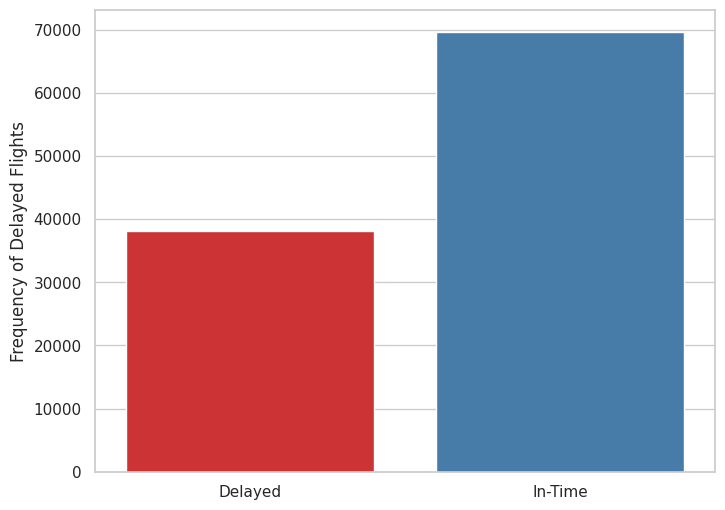

In [3]:
# Create a countplot
sns.set(style="whitegrid")  # Set the plot style
plt.figure(figsize=(8, 6))  # Set the figure size

# Use sns.countplot to plot the frequency of 'delayed'
ax = sns.countplot(data=df, x='delayed', palette="Set1")

# Set custom labels for the x-axis
ax.set_xticklabels(["Delayed", "In-Time"])
ax.set_xlabel('')
plt.ylabel('Frequency of Delayed Flights')

In [4]:
# Splitting data for training and testing
X = df.drop(['target','delayed'],axis=1)
y = df['delayed'] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle = True,random_state=42,stratify=y)

# There is an imbalance between delayed and in-time data.
# Synthetic Minority Over-sampling Technique (SMOTE)
# to address class imbalance in our training data

smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X_train, y_train.ravel())

print('Shape of Training features: {}'.format(X_resample.shape))
print('Shape of Training targets: {}'.format(y_resample.shape))
print('Shape of Testing features: {}'.format(X_test.shape))
print('Shape of Testing targets: {}'.format(y_test.shape))

Shape of Training features: (97530, 24)
Shape of Training targets: (97530,)
Shape of Testing features: (32350, 24)
Shape of Testing targets: (32350,)


In [7]:
sum(1-y_test)

11450

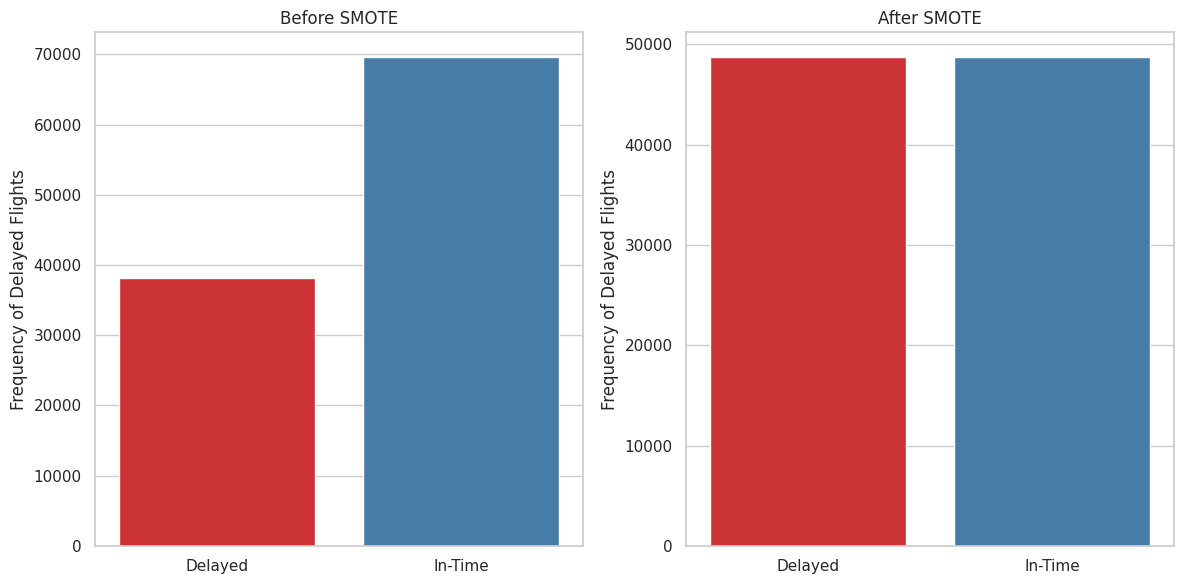

In [9]:
# Compare class imbalance after SMOTE
sns.set(style="whitegrid")  # Set the plot style
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the original class distribution
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df, x='delayed', palette="Set1")
ax1.set_xticklabels(["Delayed", "In-Time"])
ax1.set_xlabel('')
plt.ylabel('Frequency of Delayed Flights')
plt.title("Before SMOTE")

# Plot the resampled class distribution
plt.subplot(1, 2, 2)
ax2 = sns.countplot(data=pd.DataFrame({'delayed': y_resample}), x='delayed', palette="Set1")
ax2.set_xticklabels(["Delayed", "In-Time"])
ax2.set_xlabel('')
plt.ylabel('Frequency of Delayed Flights')
plt.title("After SMOTE")

plt.tight_layout()


In [10]:
# Baseline model for classification
# Null accuracy Score for current data
NUll_acc = round (max(y_test.mean(), 1 - y_test.mean()), 2)

print('Null Accuracy Score for Current Data is {}'.format(NUll_acc))

#Info:
# Null Accuracy Score is a metric used to evaluate classification models,
# and it represents the accuracy that could be achieved by always predicting 
# the majority class in a binary classification problem.

Null Accuracy Score for Current Data is 0.65


In [11]:

# Function for prediction using SVC,DTC,AdaBoostC,RandomForestC,GradientBoostC,KNC,LR,XGBC,LGBMC
def predictions(x_set,y_set):
    t1 = time.time()
    print('Classification Process Starts....')
    accuracy,precision,recall,f1,auc,conf_mat= [],[],[],[],[],[]
        
    random_state = 2023
    
    ##classifiers list 
    classifiers = []
    # classifiers.append(SVC(random_state=random_state, probability = True))
    classifiers.append(DecisionTreeClassifier(random_state=random_state))
    classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state)))
    classifiers.append(RandomForestClassifier(random_state=random_state))
    classifiers.append(GradientBoostingClassifier(random_state=random_state))
    classifiers.append(KNeighborsClassifier())
    classifiers.append(LogisticRegression(random_state = random_state))
    classifiers.append(XGBClassifier(random_state = random_state,eval_metric = 'logloss',learning_rate = 0.054))
    classifiers.append(LGBMClassifier(random_state = random_state,learning_rate = 0.067))


    for classifier in classifiers:
        
        t =time.time()
        print('Classifier parameters: {}'.format(classifier))
        
        #classifier and fitting
        clf = classifier
        clf.fit(x_set,y_set)
        
        #predictions
        y_preds = clf.predict(X_test)
        y_probs = clf.predict_proba(X_test)
        
        # metrics
        accuracy.append((round(accuracy_score(y_test,y_preds),2))*100)
        precision.append((round(precision_score(y_test,y_preds),2))*100)
        recall.append((round(recall_score(y_test,y_preds),2))*100)
        f1.append((round(f1_score(y_test,y_preds),2))*100)
        auc.append((round (roc_auc_score(y_test,y_probs[:,1]), 2))*100)
        conf_mat.append(confusion_matrix(y_test,y_preds))
        
        elapsed = time.time() - t
        print('Elapsed time is {}seconds'.format(round(elapsed,3)))
        print('\n')
    results_df = pd.DataFrame({"Accuracy Score":accuracy,"Precision Score":precision,
                        "Recall Score":recall, "f1 Score":f1,"AUC Score":auc,
                        "Confusion Matrix":conf_mat,
                        "Algorithm":["DecisionTree","AdaBoost",
                                     "RandomForest","GradientBoosting",
                                     "KNeighboors","LogisticRegression",
                                     "XGBoost", "LightGBM"]})
                        # "Algorithm":["SVC","DecisionTree","AdaBoost",
                        #              "RandomForest","GradientBoosting",
                        #              "KNeighboors","LogisticRegression",
                        #              "XGBoost", "LightGBM"]})
    
    results_df = (results_df.sort_values(by = 'Algorithm', ascending = False)
                  .reset_index(drop =  True))
    t2 = time.time() - t1
    print('\nClassification is Completed and results are strored in dataframe.\ntotal time elapsed is {}seconds'.format(t2))
    print('***************************************************************\n\n')
    
    return results_df


In [12]:
orig_results = predictions(X_train,y_train)
resamp_results = predictions(X_resample,y_resample)

Classification Process Starts....
Classifier parameters: DecisionTreeClassifier(random_state=2023)
Elapsed time is 0.646seconds


Classifier parameters: AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=2023))
Elapsed time is 32.769seconds


Classifier parameters: RandomForestClassifier(random_state=2023)
Elapsed time is 11.064seconds


Classifier parameters: GradientBoostingClassifier(random_state=2023)
Elapsed time is 12.649seconds


Classifier parameters: KNeighborsClassifier()
Elapsed time is 7.786seconds


Classifier parameters: LogisticRegression(random_state=2023)
Elapsed time is 1.51seconds


Classifier parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_ty

In [13]:
# Function for visualization
def multi_visualize(data, vmin = -0.5, vmax = 1):
    fig = plt.figure(figsize =(24,24))
    gs = fig.add_gridspec(8,6)
    gs.update(wspace = 0.2, hspace = 0.1)
    
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])
    
    ax7 = fig.add_subplot(gs[2,0])
    ax8 = fig.add_subplot(gs[2,1])
    ax9 = fig.add_subplot(gs[2,2])
    
    ax10 = fig.add_subplot(gs[0,3])
    ax11 = fig.add_subplot(gs[0,4])
    ax12 = fig.add_subplot(gs[0,5])
    
    ax13 = fig.add_subplot(gs[1,3])
    ax14 = fig.add_subplot(gs[1,4])
    ax15 = fig.add_subplot(gs[1,5])
    
    ax16 = fig.add_subplot(gs[2,3])
    ax17 = fig.add_subplot(gs[2,4])
    ax18 = fig.add_subplot(gs[2,5])
    
    
    axes1 = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    axes2 = [ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17]
    
    axes = [axes1,axes2]
    
    fig.patch.set_facecolor('#f6f5f5')
    
    # setting of axes; visibility of axes and spines turn off
    for ax_list in axes:
        for ax in ax_list:
            ax.axes.get_yaxis().set_visible(False)
            ax.axes.get_xaxis().set_visible(False)
            ax.set_facecolor('#f6f5f5')

    colors = ['#512b58','#fe346e']
    colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    
    
    for ax_list in axes:
        
        if ax_list == axes1:
            res_df = data[0]
        else:
            res_df = data[1]
        
        
        alg = res_df['Algorithm']
        cf = res_df['Confusion Matrix']
        auc = res_df['AUC Score']
        f1 = res_df['f1 Score']
        forig = data[0]['f1 Score']
        fresam = data[1]['f1 Score']
        
        n = 0
        for ax in ax_list:
            cf_mat = cf[n]
            
            #### annotations
            labels = ['True Neg','False Pos','False Neg','True Pos']
            counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
            percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten()/np.sum(cf_mat)]
            
            #### final annotations
            label = (np.array([f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,counts,percentages)])).reshape(2,2)
            
            #### heatmap
            sns.heatmap(data = cf_mat, vmin = vmin, vmax =vmax, cmap = ['grey'],linewidth=2,linecolor = '#f6f5f5',
               ax = ax, annot = label, fmt ='', cbar = False, annot_kws = {'font':'serif','size':10, 'color':'white','weight':'bold'}, alpha =0.8)
            
            #### subtitle
            if ax_list == axes1:
                ax.text(0,-0,'{}'.format(alg[n]),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
            else:
                ax.text(0,-0,'SMOTE {}'.format(alg[n]),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
           
        
            #### Auc and F1 score plotting
            
            if ax_list == axes2:
                if (fresam[n] > forig[n]) & (auc[n] > 75):
                    ax.scatter( 1 , 1 , s = 3500, c = '#fe346e')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
                else:
                    ax.scatter( 1 , 1 , s = 3500, c = 'white')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
               
            else:
                if (forig[n] > 5 ) & (auc[n] > 75):
                    ax.scatter( 1 , 1 , s = 3500, c = '#512b58', alpha = 0.9)
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'white', 'weight':'bold'})
                else:
                    ax.scatter( 1 , 1 , s = 3500, c = 'white')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'font':'serif','size':12, 'color':'black', 'weight':'bold'})
            
           
            n +=1
        if ax_list == axes1:
            ax1.text(0,-0.55,'Visualization of Results with - Original Data',{'font':'serif','size':24, 'color':'black', 'weight':'bold'},)
        else:
            ax10.text(0,-0.55,'Visualization of Results with - Oversampled Data',{'font':'serif','size':24, 'color':'black', 'weight':'bold'}, alpha = 0.9)
            
            
    fig.show()

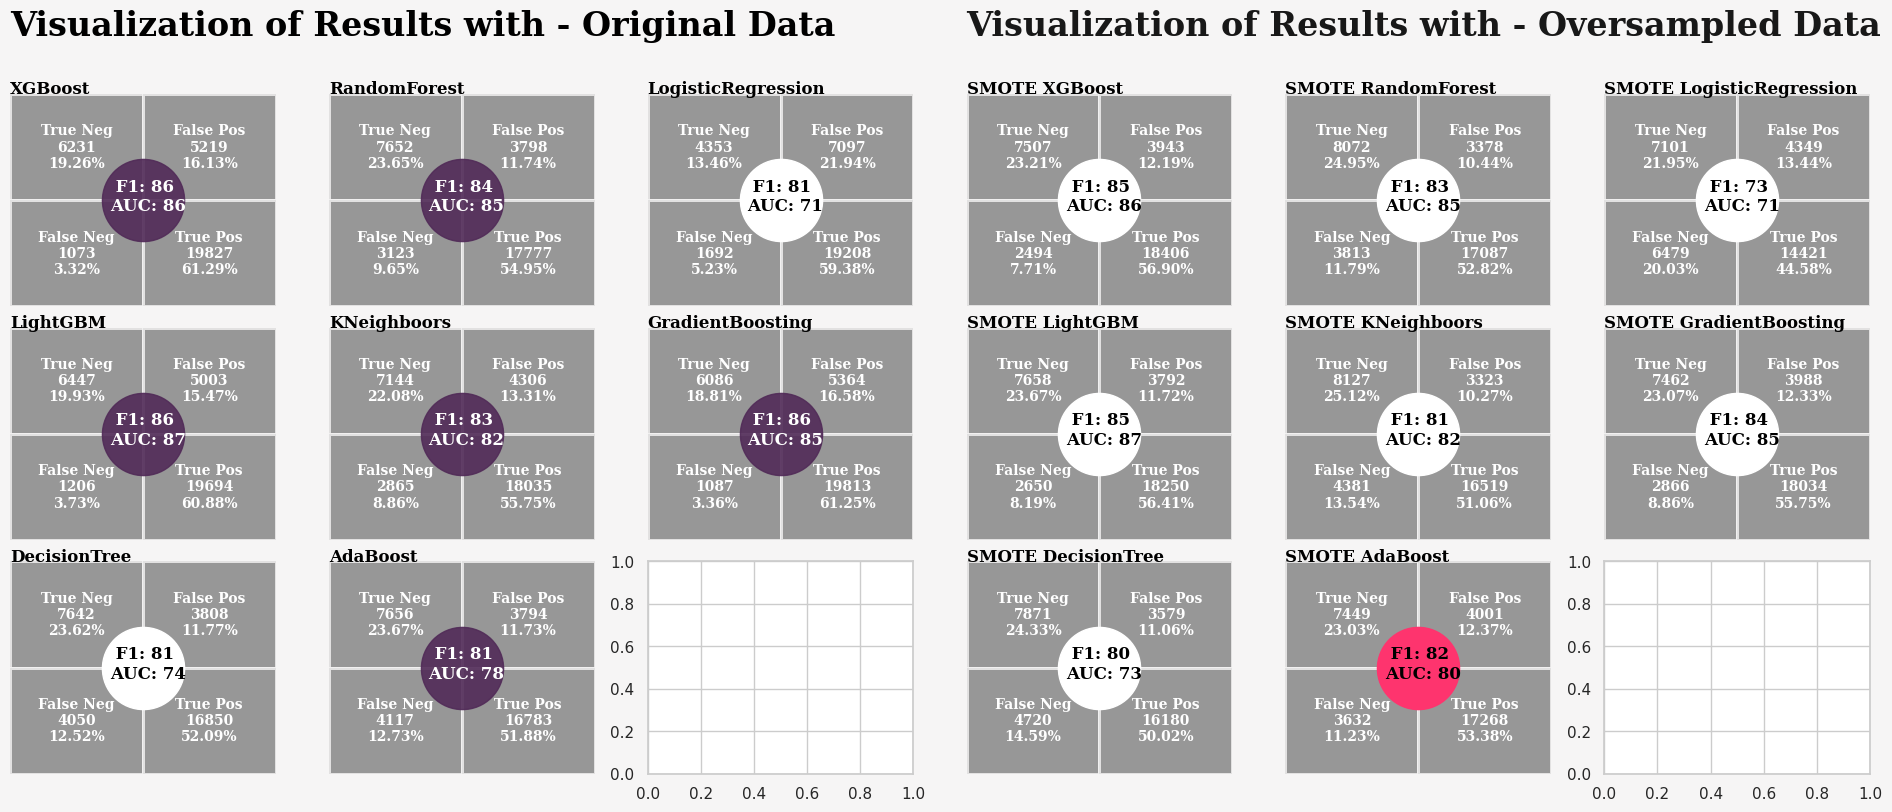

In [14]:
multi_visualize(data = [orig_results, resamp_results], vmin=30,vmax = 100)